# WP4: Climatology and Bias - Precipitation

## Import libraries

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import skill_metrics
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")

## Define Parameters

In [2]:
# Time
year_start = 1985
year_stop = 1987

# Choose CORDEX or CMIP6
collection_id = "projections-cordex-domains-single-levels"  # "projections-cmip6"

# Define region for analysis
lon_slice = slice(-4, 20)
lat_slice = slice(35, 50)

# Define region for request
cordex_domain = "europe"

# Chunks for download
chunks = {"year": 1}
assert "month" not in chunks, "Do not use chunks smaller than 1y"

## Define models

In [3]:
models_cordex = [
    "clmcom_clm_cclm4_8_17",
    "clmcom_eth_cosmo_crclim",
    "cnrm_aladin63",
    "dmi_hirham5",
    "knmi_racmo22e",
    "mohc_hadrem3_ga7_05",
    "mpi_csc_remo2009",
    "smhi_rca4",
    "uhoh_wrf361h",
]

models_cmip6 = [
    "access_cm2",
    "awi_esm_1_1_lr",
    "bcc_esm1",
    "cesm2_fv2",
    "cnrm_cm6_1",
    "fgoals_g3",
]

## Define ERA5 request

In [4]:
request_era = (
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "format": "netcdf",
        "time": "00:00",
        "variable": "mean_total_precipitation_rate",
        "year": [str(year) for year in range(year_start, year_stop + 1)],
        "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    },
)

## Define model requests

In [5]:
request_cordex = {
    "format": "zip",
    "domain": cordex_domain,
    "experiment": "historical",
    "horizontal_resolution": "0_11_degree_x_0_11_degree",
    "temporal_resolution": "monthly_mean",
    "variable": "mean_precipitation_flux",
    "gcm_model": "mpi_m_mpi_esm_lr",
    "ensemble_member": "r1i1p1",
}

request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "monthly",
    "experiment": "historical",
    "variable": "precipitation",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
}


def get_cordex_years(
    year_start,
    year_stop,
    start_years=[1971, 1981, 1991, 2001],
    end_years=[1980, 1990, 2000, 2005],
):
    start_year = []
    end_year = []
    years = set(range(year_start, year_stop + 1))
    for start, end in zip(start_years, end_years):
        if years & set(range(start, end + 1)):
            start_year.append(start)
            end_year.append(end)
    return start_year, end_year


if collection_id == "projections-cordex-domains-single-levels":
    weights = False  # Do not weight spatial statistics/errors
    periodic = False
    models = models_cordex
    model_key = "rcm_model"
    request_sim = (
        collection_id,
        [
            {
                **request_cordex,
                "start_year": start_year,
                "end_year": end_year,
            }
            for start_year, end_year in zip(*get_cordex_years(year_start, year_stop))
        ],
    )
elif collection_id == "projections-cmip6":
    weights = True  # Weight spatial statistics/errors
    periodic = True
    models = models_cmip6
    model_key = "model"
    request_sim = (
        "projections-cmip6",
        download.split_request(request_cmip6, chunks=chunks),
    )
else:
    raise ValueError(f"{collection_id=} is not supported for this notebook.")

## Define transform function

In [6]:
def compute_annual_regridded_precipitation(
    ds, model, year_start, year_stop, grid_out=None, **kwargs
):
    varname = "mtpr" if model == "ERA5" else "pr"
    mask = ds["time"].dt.year.isin(range(year_start, year_stop + 1))
    ds = ds[[varname]].where(mask.compute(), drop=True)

    ds = diagnostics.annual_weighted_mean(ds)
    if grid_out is not None:
        ds = diagnostics.regrid(ds, grid_out, **kwargs)

    # Change units
    varname = "mtpr" if model == "ERA5" else "pr"
    with xr.set_options(keep_attrs=True):
        ds[varname] = ds[varname] * 3600 * 24
    ds[varname].attrs["units"] = "mm/day"

    return ds.rename({varname: "precipitation"}).expand_dims(model=[model])

## Download data

In [7]:
print("Downloading and processing ERA5")
ds_era = download.download_and_transform(
    *request_era,
    chunks=chunks,
    transform_func=compute_annual_regridded_precipitation,
    transform_func_kwargs={
        "model": "ERA5",
        "year_start": year_start,
        "year_stop": year_stop,
    },
)

datasets = []
for model in models:
    print(f"Downloading and processing {model}")
    request_model = request_sim
    for request in request_model[1]:
        request[model_key] = model
    ds = download.download_and_transform(
        *request_model,
        transform_func=compute_annual_regridded_precipitation,
        transform_func_kwargs={
            "grid_out": ds_era[["longitude", "latitude"]],
            "model": model,
            "year_start": year_start,
            "year_stop": year_stop,
            "method": "bilinear",
            "periodic": periodic,
        },
    )
    datasets.append(ds)
ds_sim = xr.concat(datasets, "model")

 67%|██████▋   | 2/3 [00:01<00:00,  1.77it/s]2023-05-16 16:20:28,003 INFO Welcome to the CDS
2023-05-16 16:20:28,004 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-05-16 16:20:28,102 INFO Request is completed
2023-05-16 16:20:28,104 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data9/adaptor.mars.internal-1684240773.9187665-29010-13-5f681dab-7563-4b55-8b7c-3b7d42f739cb.nc to adaptor.mars.internal-1684240773.9187665-29010-13-5f681dab-7563-4b55-8b7c-3b7d42f739cb.nc (23.8M)
2023-05-16 16:20:29,266 INFO Download rate 20.5M/s
100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:20:38,752 INFO Welcome to the CDS
2023-05-16 16:20:38,753 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:20:39,044 INFO Request is queued
2023-05-16 16:20:40,073 INFO Request is running
2023-05-16 16:21:28,542 INFO Request is completed
2023-05-16 16:21:28,543 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data9/dataset-projections-cordex-domains-single-levels-14746ea6-ce57-4909-9e88-9920a69dd498.zip to dataset-projections-cordex-domains-single-levels-14746ea6-ce57-4909-9e88-9920a69dd498.zip (85.2M)
2023-05-16 16:21:32,400 INFO Download rate 22.1M/s
100%|██████████| 1/1 [01:01<00:00, 61.09s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:21:40,067 INFO Welcome to the CDS
2023-05-16 16:21:40,067 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:21:40,281 INFO Request is completed
2023-05-16 16:21:40,282 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data9/dataset-projections-cordex-domains-single-levels-3904bbfb-93ce-4dfd-93ad-2e5e28d749b9.zip to dataset-projections-cordex-domains-single-levels-3904bbfb-93ce-4dfd-93ad-2e5e28d749b9.zip (82.7M)
2023-05-16 16:21:46,156 INFO Download rate 14.1M/s
100%|██████████| 1/1 [00:13<00:00, 13.32s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:21:53,532 INFO Welcome to the CDS
2023-05-16 16:21:53,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:21:53,661 INFO Request is completed
2023-05-16 16:21:53,662 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data8/dataset-projections-cordex-domains-single-levels-59556b19-7c36-468f-9528-8de7c29a0cc7.zip to dataset-projections-cordex-domains-single-levels-59556b19-7c36-468f-9528-8de7c29a0cc7.zip (62.6M)
2023-05-16 16:21:57,847 INFO Download rate 15M/s
100%|██████████| 1/1 [00:12<00:00, 12.56s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:22:06,266 INFO Welcome to the CDS
2023-05-16 16:22:06,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:22:06,379 INFO Request is queued
2023-05-16 16:22:07,407 INFO Request is running
2023-05-16 16:22:55,874 INFO Request is completed
2023-05-16 16:22:55,875 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data0/dataset-projections-cordex-domains-single-levels-6cd4bfc1-c928-443b-8faf-d1a53dcc6664.zip to dataset-projections-cordex-domains-single-levels-6cd4bfc1-c928-443b-8faf-d1a53dcc6664.zip (70.5M)
2023-05-16 16:22:59,467 INFO Download rate 19.6M/s
100%|██████████| 1/1 [01:01<00:00, 61.72s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:23:08,244 INFO Welcome to the CDS
2023-05-16 16:23:08,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:23:08,498 INFO Request is completed
2023-05-16 16:23:08,500 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data1/dataset-projections-cordex-domains-single-levels-73f71bac-49ff-4e32-a886-50fbba2fd3bd.zip to dataset-projections-cordex-domains-single-levels-73f71bac-49ff-4e32-a886-50fbba2fd3bd.zip (65.9M)
2023-05-16 16:23:13,077 INFO Download rate 14.4M/s
100%|██████████| 1/1 [00:13<00:00, 13.05s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:23:21,572 INFO Welcome to the CDS
2023-05-16 16:23:21,572 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:23:21,723 INFO Request is queued
2023-05-16 16:23:22,753 INFO Request is running
2023-05-16 16:23:54,178 INFO Request is completed
2023-05-16 16:23:54,179 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data3/dataset-projections-cordex-domains-single-levels-8bcd9396-26d3-46a1-bc63-cc9c32e2a174.zip to dataset-projections-cordex-domains-single-levels-8bcd9396-26d3-46a1-bc63-cc9c32e2a174.zip (49.4M)
2023-05-16 16:23:56,518 INFO Download rate 21.1M/s
100%|██████████| 1/1 [00:41<00:00, 41.47s/it]


  0%|          | 0/1 [00:00<?, ?it/s]2023-05-16 16:24:03,225 INFO Welcome to the CDS
2023-05-16 16:24:03,225 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-05-16 16:24:03,437 INFO Request is queued
2023-05-16 16:24:04,468 INFO Request is running
2023-05-16 16:24:52,949 INFO Request is completed
2023-05-16 16:24:52,950 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data0/dataset-projections-cordex-domains-single-levels-f5de1549-b629-4731-bf7d-53f4151c80c4.zip to dataset-projections-cordex-domains-single-levels-f5de1549-b629-4731-bf7d-53f4151c80c4.zip (64.7M)
2023-05-16 16:24:55,860 INFO Download rate 22.3M/s
100%|██████████| 1/1 [00:55<00:00, 55.15s/it]


## Create a single dataset and compute bias

In [8]:
ds_annual = xr.concat(
    [ds_sim, ds_sim.mean("model").expand_dims(model=["ensemble"]), ds_era], "model"
)
ds_annual = utils.regionalise(ds_annual, lon_slice=lon_slice, lat_slice=lat_slice)

with xr.set_options(keep_attrs=True):
    ds = ds_annual.mean("year")
    ds_bias = ds.drop_sel(model="ERA5") - ds.sel(model="ERA5")
for da in ds_bias.data_vars.values():
    da.attrs["long_name"] += " Bias"

## Plot Maps

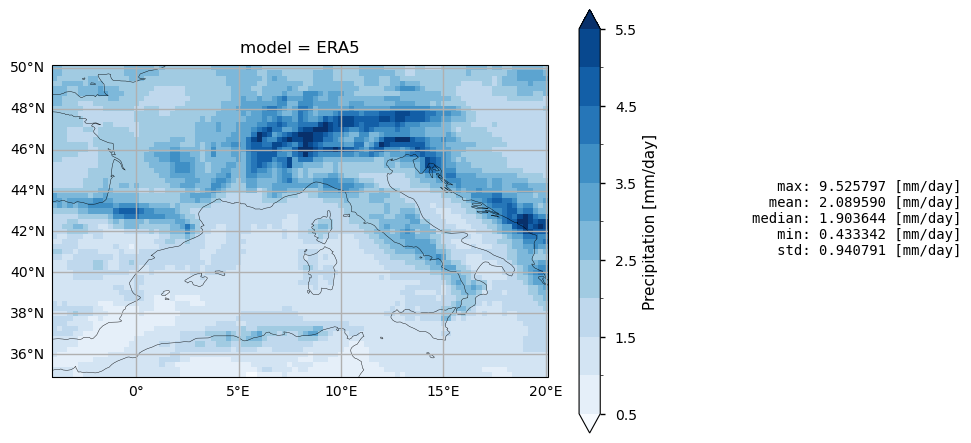

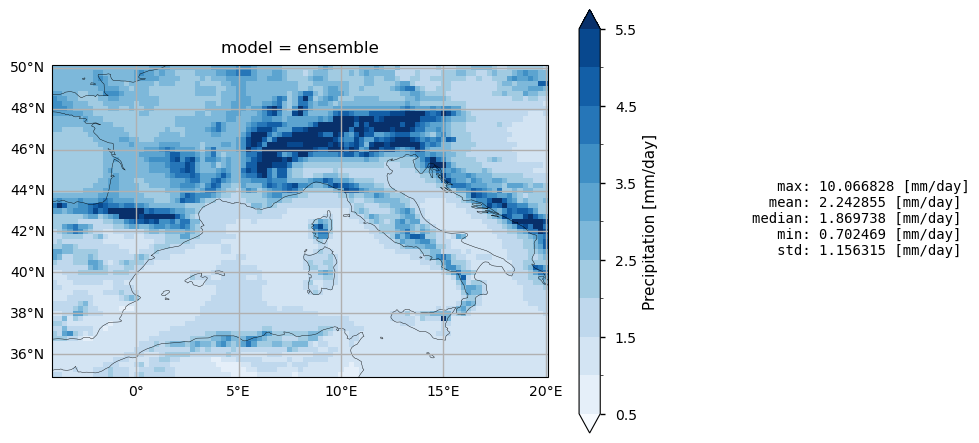

In [9]:
# Choose projection
Projection = (
    ccrs.Robinson
    if abs(lon_slice.stop - lon_slice.start) == 360
    and abs(lat_slice.stop - lat_slice.start) == 180
    else ccrs.PlateCarree
)
projection = Projection(central_longitude=(lon_slice.stop + lon_slice.start) / 2)

da_to_plot = ds["precipitation"].sel(model=["ensemble", "ERA5"])
plot_kwargs = xr.plot.utils._determine_cmap_params(
    da_to_plot.values, robust=True, levels=10, cmap="Blues"
)
plot_kwargs["projection"] = projection
for _, da_to_plot in da_to_plot.groupby("model"):
    plot.projected_map(da_to_plot, **plot_kwargs)
    plt.show()

## Plot Bias

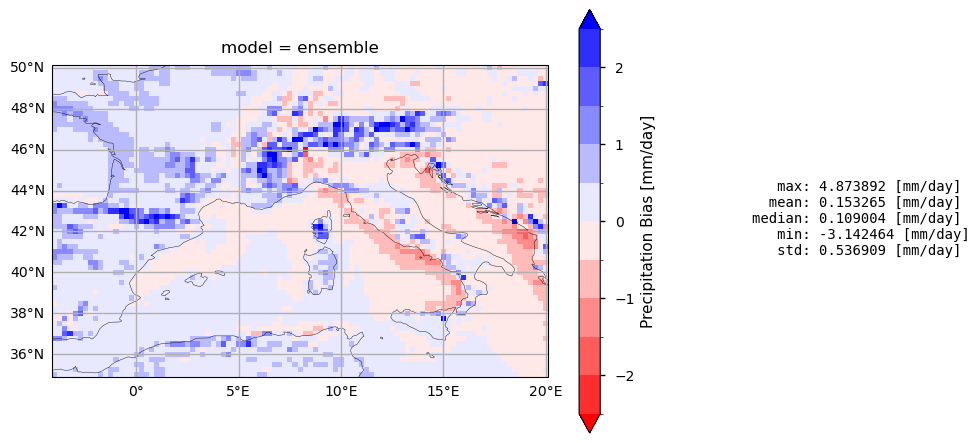

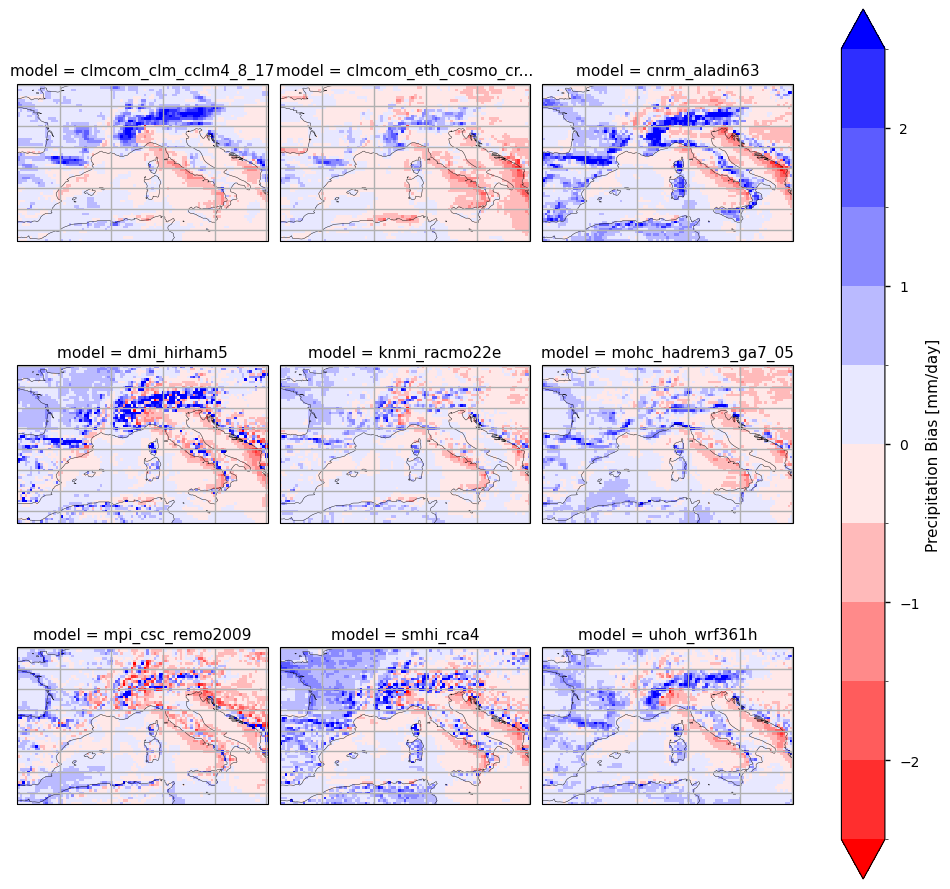

In [10]:
plot_kwargs = xr.plot.utils._determine_cmap_params(
    ds_bias["precipitation"].values, robust=True, levels=11, cmap="bwr_r"
)
plot_kwargs["projection"] = projection
plot.projected_map(ds_bias["precipitation"].sel(model=["ensemble"]), **plot_kwargs)
plt.show()
facet = plot.projected_map(
    ds_bias["precipitation"].drop_sel(model="ensemble"),
    col="model",
    col_wrap=min(3, ds_bias.sizes["model"] - 1),
    **plot_kwargs,
)

## Plot KDE and Statistics of Bias

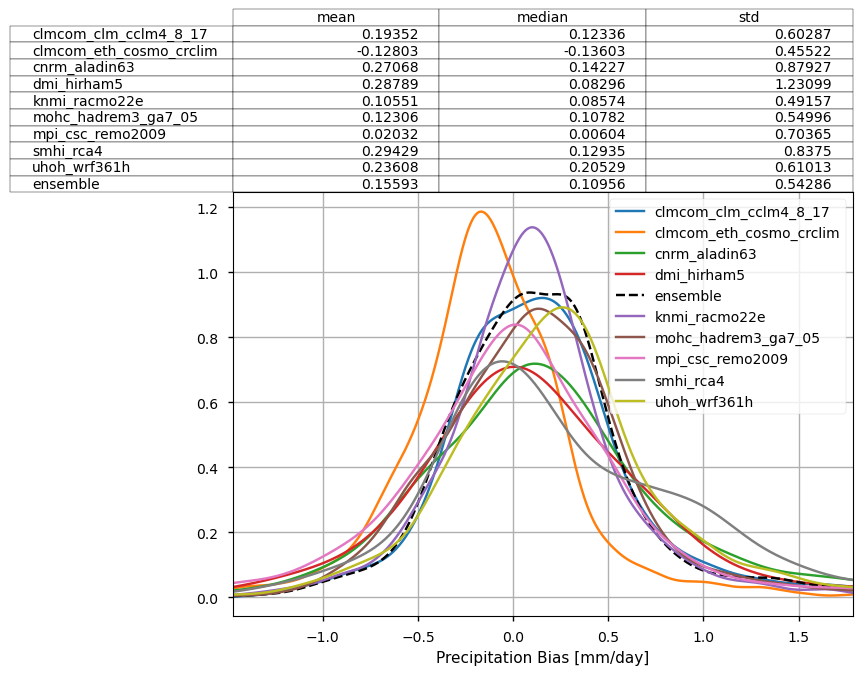

In [11]:
# Create dataframe
da = ds_bias["precipitation"]
df_stats = diagnostics.spatial_weighted_statistics(da, weights=weights).to_pandas()

# Plot
fig, ax = plt.subplots(1, 1)
x = np.linspace(
    df_stats["ensemble"]["mean"] - 3 * df_stats["ensemble"]["std"],
    df_stats["ensemble"]["mean"] + 3 * df_stats["ensemble"]["std"],
    1_000,
)
for model, values in da.groupby("model"):
    y = values.stack(dim=values.dims).dropna("dim")
    gkde = scipy.stats.gaussian_kde(
        y, weights=np.cos(np.deg2rad(y["latitude"])) if weights else None
    )
    ax.plot(
        x,
        gkde.evaluate(x),
        color="k" if model == "ensemble" else None,
        ls="--" if model == "ensemble" else "-",
        label=model,
    )
ax.grid()
ax.set_xlim(x[[0, -1]])
ax.set_xlabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
ax.legend()

# Add stats
table = plt.table(
    cellText=df_stats.round(5).T.values.tolist(),
    colLabels=df_stats.T.columns.values.tolist(),
    rowLabels=df_stats.T.index.values.tolist(),
    loc="top",
)

## Compute and Show Statistics

In [12]:
ds_stats = diagnostics.spatial_weighted_statistics(ds, weights=weights)
ds_error = diagnostics.spatial_weighted_errors(
    ds.drop_sel(model="ERA5"), ds.sel(model="ERA5"), weights=weights
)
df_stats_and_error = xr.merge([ds_stats, ds_error])["precipitation"].to_pandas()
df_stats_and_error

model,ERA5,clmcom_clm_cclm4_8_17,clmcom_eth_cosmo_crclim,cnrm_aladin63,dmi_hirham5,ensemble,knmi_racmo22e,mohc_hadrem3_ga7_05,mpi_csc_remo2009,smhi_rca4,uhoh_wrf361h
diagnostic,,,,,,,,,,,
corr,NaN,0.915351,0.900914,0.773228,0.740281,0.889188,0.890007,0.864677,0.773769,0.786076,0.857806
crmse,NaN,0.602868,0.455225,0.879270,1.230986,0.542856,0.491570,0.549957,0.703647,0.837500,0.610128
mean,2.129939,2.323462,2.001906,2.400621,2.417827,2.285864,2.235450,2.253002,2.150254,2.424231,2.366022
median,1.953754,1.973802,1.722249,1.996065,1.878506,1.938014,1.936678,1.921201,1.821660,2.017738,2.030424
rmse,NaN,0.633167,0.472887,0.919992,1.264202,0.564805,0.502766,0.563558,0.703941,0.887701,0.654211
std,0.944970,1.332601,1.048911,1.374134,1.753925,1.168513,1.077682,1.094812,1.101037,1.342998,1.179875


## Taylor Dyagram

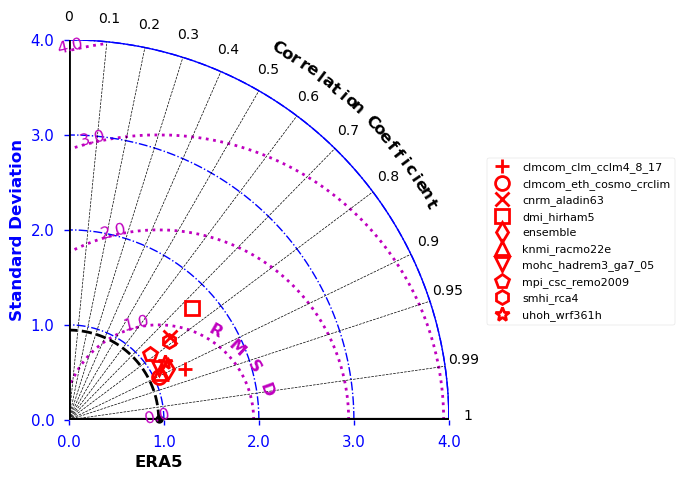

In [13]:
skill_metrics.taylor_diagram(
    df_stats_and_error.loc["std"].values,
    df_stats_and_error.loc["crmse"].values,
    df_stats_and_error.loc["corr"].values,
    alpha=0.0,
    axismax=4,
    colCOR="k",
    colOBS="k",
    colRMS="m",
    colSTD="b",
    markerColor="r" if len(df_stats_and_error.columns) >= 9 else None,  # TODO
    markerLabel=list(df_stats_and_error.columns),
    markerLegend="on",
    markerSize=10,
    markerobs="o",
    styleCOR="--",
    styleOBS="--",
    styleRMS=":",
    styleSTD="-.",
    tickRMS=np.linspace(0, 4, 5),
    tickSTD=np.linspace(0, 4, 5),
    titleCOR="on",
    titleOBS="ERA5",
    titleRMS="on",
    titleRMSDangle=40.0,
    titleSTD="on",
    widthCOR=0.5,
    widthOBS=2,
    widthRMS=2,
    widthSTD=1.0,
)